In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
# import signal_generation as sg
# import channel_model as ch
import hpcom
from tqdm import tqdm
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score
# from sklearn.externals import joblib
from datetime import datetime
from importlib import reload
reload(hpcom)

from composer import *
from estimator import *


In [2]:
# path_to_data = 'C:/Users/190243539/PycharmProjects/nn_essential/error_statistics/data/data_collected_3.pkl'
path_to_data = 'C:/Users/190243539/PycharmProjects/nn_essential/benchmark/data/data_collected_extended_wo_noise_1.pkl'
path_to_data_w_noise = 'C:/Users/190243539/PycharmProjects/nn_essential/benchmark/data/data_collected_extended_w_noise_1.pkl'

df = pd.read_pickle(path_to_data)
df_noise = pd.read_pickle(path_to_data_w_noise)


n_neighbours = 4
n_gauss = 5
# train_runs = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
# train_runs = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
train_runs = [0, 1, 2]
test_runs = [0, 1]

p_ave_dbm = 6
z_km = 80 * 20
n_channels = 1
sigma = 1.5

df_tree = get_data_with_m_neighbor(df, z_km, p_ave_dbm, n_channels, train_runs, n_neighbours, r=0.1, n_gauss=n_gauss)
df_tree_for_test = get_data_with_m_neighbor(df_noise, z_km, p_ave_dbm, n_channels, test_runs, n_neighbours, r=0.1, n_gauss=n_gauss)

# df_tree = get_data_gauss_parallel(df, z_km, p_ave_dbm, n_channels, train_runs, n_neighbours, r=0.1, n_gauss=n_gauss, sigma=sigma)
# df_tree_for_test = get_data_gauss_parallel(df, z_km, p_ave_dbm, n_channels, test_runs, n_neighbours, r=0.1, n_gauss=1, sigma=sigma)

print(df_tree.head())
df = pd.DataFrame([])
df_noise = pd.DataFrame([])
del df, df_noise

['point_orig_abs', 'point_orig_angle', 'point_label', 'diff_real', 'diff_imag', 'diff_sq_real', 'diff_sq_imag', 'diff_circle_real', 'diff_circle_imag', 'diff_p3_real', 'diff_p3_imag', 'diff_gauss_0_real', 'diff_gauss_1_real', 'diff_gauss_2_real', 'diff_gauss_3_real', 'diff_gauss_4_real', 'diff_gauss_0_imag', 'diff_gauss_1_imag', 'diff_gauss_2_imag', 'diff_gauss_3_imag', 'diff_gauss_4_imag', 'minus_m_4_x_abs', 'minus_m_3_x_abs', 'minus_m_2_x_abs', 'minus_m_1_x_abs', 'point_x_abs', 'plus_m_1_x_abs', 'plus_m_2_x_abs', 'plus_m_3_x_abs', 'plus_m_4_x_abs', 'minus_m_4_x_angle', 'minus_m_3_x_angle', 'minus_m_2_x_angle', 'minus_m_1_x_angle', 'point_x_angle', 'plus_m_1_x_angle', 'plus_m_2_x_angle', 'plus_m_3_x_angle', 'plus_m_4_x_angle', 'minus_m_4_y_abs', 'minus_m_3_y_abs', 'minus_m_2_y_abs', 'minus_m_1_y_abs', 'point_y_abs', 'plus_m_1_y_abs', 'plus_m_2_y_abs', 'plus_m_3_y_abs', 'plus_m_4_y_abs', 'minus_m_4_y_angle', 'minus_m_3_y_angle', 'minus_m_2_y_angle', 'minus_m_1_y_angle', 'point_y_angle'

In [4]:
labels_to_drop = ['point_orig_abs', 'point_orig_angle',
                  'point_label',
                  'diff_real', 'diff_imag',
                  'diff_sq_real', 'diff_sq_imag',
                  'diff_circle_real', 'diff_circle_imag',
                  'diff_p3_real', 'diff_p3_imag']

# for get_data_with_m_neighbor
labels_to_drop = labels_to_drop + [f'diff_gauss_{m}_real' for m in range(n_gauss)] + [f'diff_gauss_{m}_imag' for m in range(n_gauss)]

# for get_data_gauss_parallel
# labels_to_drop = labels_to_drop + [f'diff_gauss_real'] + [f'diff_gauss_imag']

# chose what to predict
# label_predict = ['diff_circle_real', 'diff_circle_imag']
label_predict = ['diff_real', 'diff_imag']
m = 5
# label_predict = [f'diff_gauss_{m}_real', f'diff_gauss_{m}_imag']
# label_predict = [f'diff_gauss_real', f'diff_gauss_imag']
# label_predict = ['diff_p3_real', 'diff_p3_imag']
# label_predict = ['point_label']

In [5]:
X_for_test = df_tree_for_test.drop(labels=labels_to_drop, axis=1)
points_init_for_test = df_tree_for_test['point_orig_abs'].values * np.exp(1.0j * df_tree_for_test['point_orig_angle'])
labels_for_test = df_tree_for_test['point_label']

In [6]:
y = df_tree[[label_predict[0], label_predict[1]]].values
X = df_tree.drop(labels=labels_to_drop, axis=1)

In [7]:
split_ratio = 0.01
random_state = 42

# X_train, X_test, y_real_train, y_real_test = train_test_split(X, y_real, test_size=split_ratio, random_state=random_state)
# _, _, y_imag_train, y_imag_test = train_test_split(X, y_imag, test_size=split_ratio, random_state=random_state)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split_ratio, random_state=random_state)
po_abs_train, po_abs_test, po_angle_train, po_angle_test = train_test_split(df_tree['point_orig_abs'].values, df_tree['point_orig_angle'].values, test_size=split_ratio, random_state=random_state)

## Random Forest

In [12]:
n_estimators = 200
random_state_for_tree = 73
start_time = datetime.now()
# model = RandomForestRegressor(n_estimators=n_estimators, random_state=random_state_for_tree, n_jobs=13, verbose=1)
model.warm_start = True  # start from previous state of the forest (add new trees)
model.n_estimators += n_estimators
model.fit(X_train, y_train)
print("model real took", (datetime.now() - start_time).total_seconds() * 1000, "ms")

[Parallel(n_jobs=13)]: Using backend ThreadingBackend with 13 concurrent workers.
[Parallel(n_jobs=13)]: Done  24 tasks      | elapsed:  1.9min
[Parallel(n_jobs=13)]: Done 174 tasks      | elapsed: 13.2min


model real took 891608.075 ms


[Parallel(n_jobs=13)]: Done 200 out of 200 | elapsed: 14.9min finished


In [13]:
points_orig_for_test, points_predict_for_test = predict_and_eval(model, X_for_test, points_init_for_test, p_ave_dbm, name='new data test')
_ = predict_and_eval(model, X_test, po_abs_test * np.exp(1.0j * po_angle_test), p_ave_dbm, name='same data test')
points_orig_train, points_predict_train = predict_and_eval(model, X_train, po_abs_train * np.exp(1.0j * po_angle_train), p_ave_dbm, name='same data train')

P_ave [dBm] =  6


[Parallel(n_jobs=13)]: Using backend ThreadingBackend with 13 concurrent workers.
[Parallel(n_jobs=13)]: Done  24 tasks      | elapsed:    1.8s
[Parallel(n_jobs=13)]: Done 174 tasks      | elapsed:   16.4s
[Parallel(n_jobs=13)]: Done 400 out of 400 | elapsed:   25.8s finished


-----new data test-----
Number of points (131072,)
ber (orig / pred / delta) ((0.05057525634765625, 26516) / (0.04800987243652344, 25171) / 0.0025653839111328125)
ber from EVM_rms (orig / pred / delta) (0.05181239779012621 / 0.024543049983117137 / 0.027269347807009073)
q-factor [dB] (orig / pred / delta) (4.293175989992135 / 4.425487988663313 / 0.13231199867117827)
EVM [%] (orig / pred / delta) (30.163047603269554 / 24.276262214807243 / 5.886785388462313
P_ave [dBm] =  6


[Parallel(n_jobs=13)]: Using backend ThreadingBackend with 13 concurrent workers.
[Parallel(n_jobs=13)]: Done  24 tasks      | elapsed:    4.5s
[Parallel(n_jobs=13)]: Done 174 tasks      | elapsed:   11.3s
[Parallel(n_jobs=13)]: Done 400 out of 400 | elapsed:   15.2s finished


-----same data test-----
Number of points (6554,)
ber (orig / pred / delta) ((0.046917912725053405, 1230) / (0.04398077509917608, 1153) / 0.0029371376258773285)
ber from EVM_rms (orig / pred / delta) (0.05049903524271765 / 0.022495609723359067 / 0.028003425519358582)
q-factor [dB] (orig / pred / delta) (4.482897783230388 / 4.640853091583319 / 0.15795530835293103)
EVM [%] (orig / pred / delta) (29.894757379362808 / 23.77683210494229 / 6.117925274420519
P_ave [dBm] =  6


[Parallel(n_jobs=13)]: Using backend ThreadingBackend with 13 concurrent workers.
[Parallel(n_jobs=13)]: Done  24 tasks      | elapsed:    3.3s
[Parallel(n_jobs=13)]: Done 174 tasks      | elapsed:   25.1s
[Parallel(n_jobs=13)]: Done 400 out of 400 | elapsed:   50.7s finished


-----same data train-----
Number of points (648806,)
ber (orig / pred / delta) ((0.04708341168238272, 122192) / (0.00013370714820763063, 347) / 0.04694970453417509)
ber from EVM_rms (orig / pred / delta) (0.04880466128709127 / 9.144857649718903e-08 / 0.04880456983851477)
q-factor [dB] (orig / pred / delta) (4.474152807038044 / 11.23389909855415 / 6.759746291516107)
EVM [%] (orig / pred / delta) (29.54777132149855 / 8.662977192971018 / 20.88479412852753


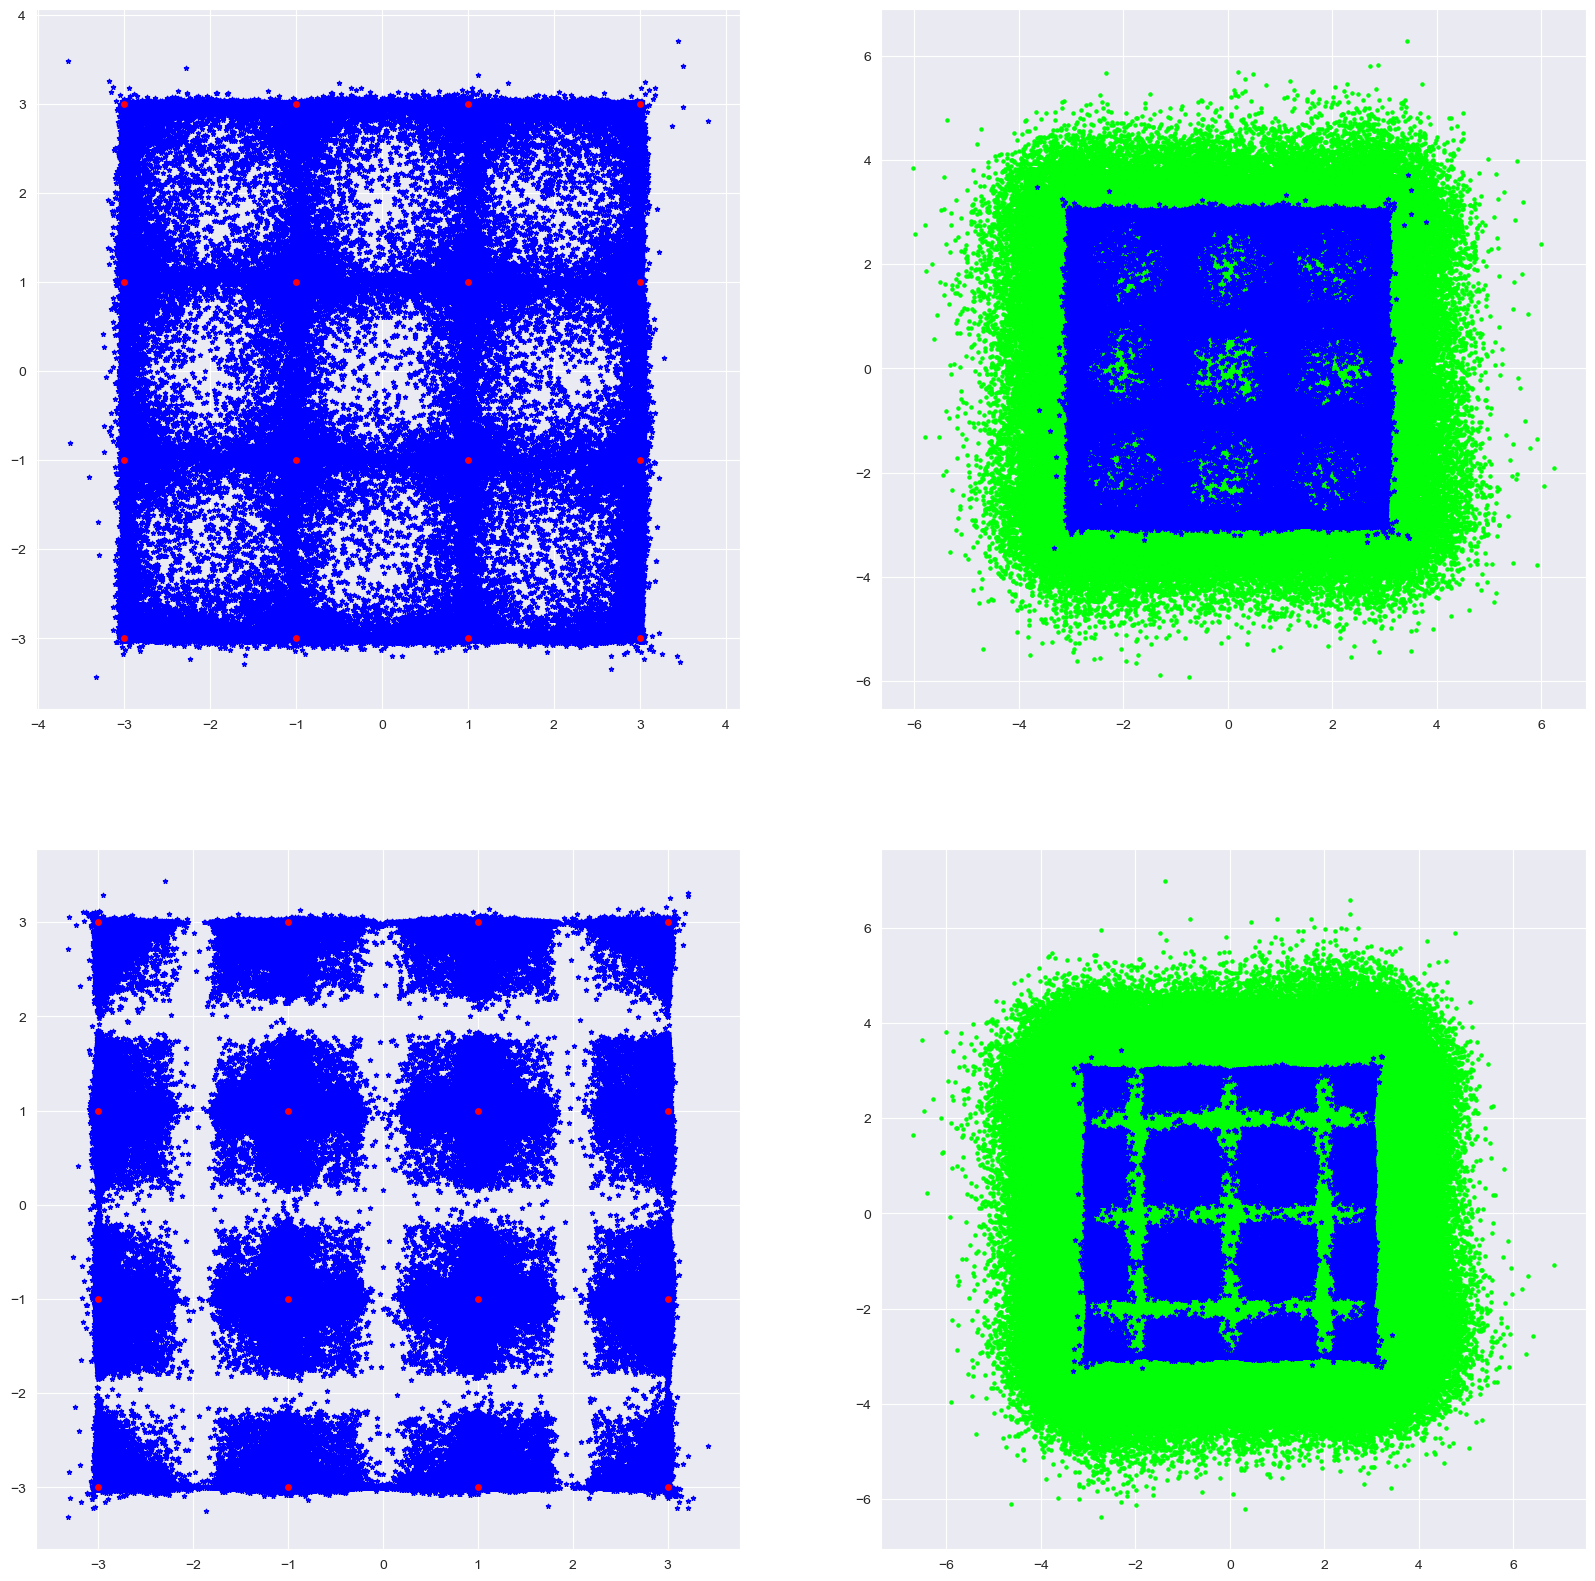

In [14]:
plot_result(p_ave_dbm, points_predict_for_test, points_orig_for_test, points_predict_train, points_orig_train)

## Boost

## K-means

In [2]:
from sklearn.cluster import KMeans


In [10]:
# path_to_data = 'C:/Users/190243539/PycharmProjects/nn_essential/error_statistics/data/data_collected_3.pkl'
path_to_data = 'C:/Users/190243539/PycharmProjects/nn_essential/benchmark/data/data_collected_extended_wo_noise_1.pkl'
path_to_data_w_noise = 'C:/Users/190243539/PycharmProjects/nn_essential/benchmark/data/data_collected_extended_w_noise_1.pkl'

df = pd.read_pickle(path_to_data)
print(df.columns.values)
print(df['p_ave_dbm'])
# df_noise = pd.read_pickle(path_to_data_w_noise)

# train_runs = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
# train_runs = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
train_runs = [0, 1, 2]
test_runs = [3, 4]

p_ave_dbm = 1
z_km = 80 * 20
n_channels = 1

df_tree = get_data_wo_neighbor(df, z_km, p_ave_dbm, n_channels, train_runs)
df_tree_for_test = get_data_wo_neighbor(df, z_km, p_ave_dbm, n_channels, test_runs)
# df_tree_for_test = get_data_wo_neighbor(df_noise, z_km, p_ave_dbm, n_channels, test_runs)


print(df_tree.head())
df = pd.DataFrame([])
df_noise = pd.DataFrame([])
del df, df_noise

['run' 'n_channels' 'p_ave_dbm' 'z_km' 'points_x_orig' 'points_x'
 'points_x_shifted' 'points_y_orig' 'points_y' 'points_y_shifted' 'ber_x'
 'ber_y' 'q_x' 'q_y']
0      1
1      1
2      1
3      1
4      1
      ..
235    8
236    8
237    8
238    8
239    8
Name: p_ave_dbm, Length: 240, dtype: int64
['point_orig_real', 'point_orig_imag', 'point_received_real', 'point_received_imag', 'point_label', 'diff_real', 'diff_imag']
run number 0
run number 1
run number 2
['point_orig_real', 'point_orig_imag', 'point_received_real', 'point_received_imag', 'point_label', 'diff_real', 'diff_imag']
run number 3
run number 4
   point_orig_real  point_orig_imag  point_received_real  point_received_imag  \
0             -3.0              1.0            -2.965415             1.174971   
1              3.0             -3.0             2.908029            -2.767121   
2             -1.0              3.0            -0.883625             2.987505   
3             -3.0             -3.0            -2.91753

In [4]:
df_tree

,point_orig_real,point_orig_imag,point_label,diff_real,diff_imag
0,3.0,3.0,15.0,0.012538,0.005790
1,1.0,1.0,10.0,0.015981,0.008266
2,-3.0,1.0,6.0,0.008664,0.004596
3,-1.0,1.0,2.0,-0.005040,0.016117
4,-1.0,-3.0,1.0,0.004353,0.003349
...,...,...,...,...,...
196603,3.0,1.0,14.0,-0.001499,0.002982
196604,-3.0,-3.0,5.0,-0.004719,0.003926
196605,-1.0,1.0,2.0,-0.006775,-0.002011
196606,1.0,-1.0,8.0,-0.003092,-0.008983


In [11]:
# X = df_tree[['point_orig_real', 'point_orig_imag']].values
X = df_tree[['point_received_real', 'point_received_imag']].values
np.shape(X)


(196608, 2)

In [16]:
# Instantiate the k-means model with the desired number of clusters
kmeans = KMeans(n_clusters=16)

# Fit the model to the data
kmeans.fit(X)

# Get the cluster assignments for each point
labels = kmeans.labels_

# Get the coordinates of the cluster centers
cluster_centers = kmeans.cluster_centers_

In [28]:
X_test = df_tree_for_test[['point_received_real', 'point_received_imag']].values

In [29]:
predictions = kmeans.predict(X_test)

In [30]:
p_pred_temp = kmeans.cluster_centers_[predictions]

In [22]:
predictions

array([14,  9,  4, ...,  6,  7,  0])

In [31]:
# p_init = df_tree[['point_orig_real', 'point_orig_imag']].values
p_init = df_tree_for_test[['point_orig_real', 'point_orig_imag']].values
p_init = p_init[:, 0] + 1j * p_init[:, 1]
# p_prop = X[:, 0] + 1j * X[:, 1]
p_prop = X_test[:, 0] + 1j * X_test[:, 1]
p_predict = p_pred_temp[:, 0] + 1j * p_pred_temp[:, 1]

In [32]:
p_ave_expl = (10 ** (p_ave_dbm / 10)) / 1000
mod_type = hpcom.modulation.get_modulation_type_from_order(16)
scale_constellation = hpcom.modulation.get_scale_coef_constellation(mod_type) / np.sqrt(p_ave_expl / 2)
constellation = hpcom.modulation.get_constellation('16qam')

p_found = hpcom.modulation.get_nearest_constellation_points_new(p_prop, constellation)
p_found_pred = hpcom.modulation.get_nearest_constellation_points_new(p_predict, constellation)

ber_orig = hpcom.metrics.get_ber_by_points(p_init, p_found, '16qam')
ber_predict = hpcom.metrics.get_ber_by_points(p_init, p_found_pred, '16qam')

print(ber_orig, ber_predict)

(1.33514404296875e-05, 7) (1.52587890625e-05, 8)


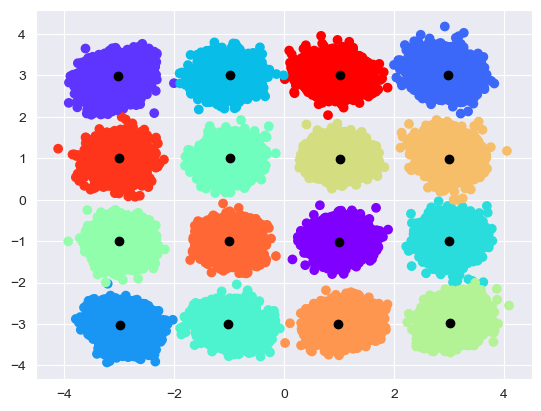

In [17]:

#Visualizing the cluster
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='rainbow')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], color='black')

## Test some features

In [9]:
import xgboost as xgb
from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error

# Generate a random dataset
X, y = make_regression(n_samples=1000, n_features=4, noise=0.1)

# Split the data into training and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Convert the data into the format required by XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Define the parameters for the XGBoost model
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'eta': 0.1,
    'max_depth': 5,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'alpha': 0.1,
    'lambda': 1.0
}

# Train the XGBoost model
num_rounds = 100
bst = xgb.train(params, dtrain, num_rounds)

# Use the trained model to make predictions on the test data
y_pred = bst.predict(dtest)

# Evaluate the performance of the model
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))

import numpy as np

def custom_objective(preds, dtrain):
    labels = dtrain.get_label()
    mse_loss = np.mean((preds - labels)**2)
    mae_loss = np.mean(np.abs(preds - labels))
    return 'custom_loss', mse_loss + mae_loss, False


params['objective'] = custom_objective
bst = xgb.train(params, dtrain, num_rounds)

y_pred = bst.predict(dtest)
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))


Mean Squared Error: 232.2542985930088


XGBoostError: [14:19:38] C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\objective\objective.cc:26: Unknown objective function: `<function custom_objective at 0x0000021DD5CC8AF0>`
Objective candidate: survival:aft
Objective candidate: binary:hinge
Objective candidate: multi:softmax
Objective candidate: multi:softprob
Objective candidate: rank:pairwise
Objective candidate: rank:ndcg
Objective candidate: rank:map
Objective candidate: reg:squarederror
Objective candidate: reg:squaredlogerror
Objective candidate: reg:logistic
Objective candidate: reg:pseudohubererror
Objective candidate: binary:logistic
Objective candidate: binary:logitraw
Objective candidate: reg:linear
Objective candidate: count:poisson
Objective candidate: survival:cox
Objective candidate: reg:gamma
Objective candidate: reg:tweedie
